In [189]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from keras.models import Sequential 
from keras.layers import Dense, GRU, Dropout 
from keras.optimizers import SGD 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
import os
import warnings
warnings.filterwarnings('ignore')

In [112]:
def set_seed(SEED = 42):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

### Sample data :: 철원 병원

In [113]:
# data read
empty_emer = pd.read_csv('../DAT/empty_emer.csv',encoding = 'CP949')
empty_emer15 = empty_emer.loc[empty_emer.hospital_name=='철원병원'].copy()

empty_emer15.drop('hospital_name',axis=1, inplace = True)
empty_emer15 = empty_emer15.rename(columns={'available_bed_num':'available_bed_num',
                                             'record_time':'record_time'})
empty_emer15['record_time'] = pd.to_datetime(empty_emer15['record_time'], format = '%Y%m%d%H%M%S')
empty_emer15 = empty_emer15.set_index('record_time')
empty_emer15.head()

,available_bed_num
record_time,
2023-06-23 09:40:01,5
2023-06-23 09:50:02,5
2023-06-23 10:00:01,5
2023-06-23 10:10:01,5
2023-06-23 10:20:01,3


In [114]:
# data split
split_rate = 0.8
data = empty_emer15

train_data = data[0:int(len(data)*split_rate)]
test_data = data[int(len(data)*split_rate)+1:]

train_data_len = len(train_data)
test_data_len = len(test_data)

print('train shape :: ', train_data.shape)
print('test shape :: ', test_data.shape)

train shape ::  (541, 1)
test shape ::  (135, 1)


<AxesSubplot:xlabel='record_time'>

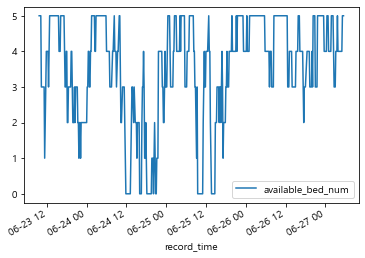

In [115]:
train_data.plot()

In [116]:
train_data_len

541

In [117]:
# 정규화
scaler = MinMaxScaler()
train_data_scaled_value = scaler.fit_transform(train_data)
test_data_scaled_value = scaler.transform(test_data)

train_data_scaled = train_data.copy()
train_data_scaled['available_bed_num'] = train_data_scaled_value

test_data_scaled = test_data.copy()
test_data_scaled['available_bed_num'] = test_data_scaled_value

In [118]:
# training 데이터의 samples 와 time steps로 원본데이터 슬라이싱 함수
def xysplit_data(train_data_scaled, test_data_scaled, 
                 train_data_len, test_data_len, time_steps, for_periods):
    x_train = [] 
    y_train = []  

    for i in range(time_steps, train_data_len):
        x_train.append(train_data_scaled[i-time_steps:i].copy())
        y_train.append(train_data_scaled[i:i+for_periods].values[0][0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # 3차원으로 재구성하기
    # x_train
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    
    # X_test 
    inputs = pd.concat((train_data_scaled, test_data_scaled), axis=0).values
    inputs = inputs[len(inputs)-len(test_data_scaled) - time_steps:]
    inputs = inputs.reshape(-1,1)

    x_test = []
    for i in range(time_steps, test_data_len + time_steps):
        x_test.append(inputs[i-time_steps:i,0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
  
    return(x_train, y_train, x_test)

In [119]:
time_steps=6
for_periods = 1
x_train, y_train, x_test = xysplit_data(train_data_scaled, test_data_scaled,
                                        train_data_len, test_data_len,
                                        time_steps, for_periods)

In [120]:
train_data_scaled.head(7)

,available_bed_num
record_time,
2023-06-23 09:40:01,1.00000
2023-06-23 09:50:02,1.00000
2023-06-23 10:00:01,1.00000
2023-06-23 10:10:01,1.00000
2023-06-23 10:20:01,0.60000
2023-06-23 10:30:01,0.60000
2023-06-23 10:40:01,0.60000


In [121]:
train_data_scaled.tail(7)

,available_bed_num
record_time,
2023-06-27 04:30:01,0.80000
2023-06-27 04:40:02,0.80000
2023-06-27 04:50:01,0.80000
2023-06-27 05:00:01,0.80000
2023-06-27 05:10:01,1.00000
2023-06-27 05:20:02,1.00000
2023-06-27 05:30:01,1.00000


In [122]:
i = train_data_len -1
train_data_scaled[i-time_steps:i]

,available_bed_num
record_time,
2023-06-27 04:30:01,0.80000
2023-06-27 04:40:02,0.80000
2023-06-27 04:50:01,0.80000
2023-06-27 05:00:01,0.80000
2023-06-27 05:10:01,1.00000
2023-06-27 05:20:02,1.00000


In [123]:
train_data_scaled[i:i+for_periods]

,available_bed_num
record_time,
2023-06-27 05:30:01,1.00000


In [124]:
x_train[0]

array([[1. ],
       [1. ],
       [1. ],
       [1. ],
       [0.6],
       [0.6]])

In [125]:
y_train[0]

0.6000000000000001

In [126]:
x_train[-1]

array([[0.8],
       [0.8],
       [0.8],
       [0.8],
       [1. ],
       [1. ]])

In [127]:
y_train[-1]

1.0

In [128]:
x_train.shape   # 541 -1 -(6(time_steps)-1)

(535, 6, 1)

In [129]:
train_data.shape

(541, 1)

In [130]:
# 3차원의 X_train을 데이터프레임 형식으로 바꿔서 눈으로 확인해보기
print('X_train 데이터프레임 형식으로 보기')
x_train_see = pd.DataFrame(np.reshape(x_train, (x_train.shape[0], x_train.shape[1])))
y_train_see = pd.DataFrame(y_train, columns = ['y_value'])
pd.concat([x_train_see, y_train_see], axis = 1).head()

X_train 데이터프레임 형식으로 보기


,0,1,2,3,4,5,y_value
0,1.00000,1.00000,1.00000,1.00000,0.60000,0.60000,0.60000
1,1.00000,1.00000,1.00000,0.60000,0.60000,0.60000,0.60000
2,1.00000,1.00000,0.60000,0.60000,0.60000,0.60000,0.60000
3,1.00000,0.60000,0.60000,0.60000,0.60000,0.60000,0.60000
4,0.60000,0.60000,0.60000,0.60000,0.60000,0.60000,0.20000


In [131]:
# 3차원의 X_test를 데이터프레임 형식으로 바꿔서 눈으로 확인해보기
x_test_see = pd.DataFrame(np.reshape(x_test, (x_test.shape[0], x_test.shape[1])))
pd.DataFrame(x_test_see).tail(10)

,0,1,2,3,4,5
125,0.80000,0.80000,0.80000,0.80000,0.80000,0.80000
126,0.80000,0.80000,0.80000,0.80000,0.80000,0.80000
127,0.80000,0.80000,0.80000,0.80000,0.80000,1.00000
128,0.80000,0.80000,0.80000,0.80000,1.00000,1.00000
129,0.80000,0.80000,0.80000,1.00000,1.00000,1.00000
130,0.80000,0.80000,1.00000,1.00000,1.00000,1.00000
131,0.80000,1.00000,1.00000,1.00000,1.00000,1.00000
132,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
133,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
134,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [132]:
x_test.shape

(135, 6, 1)

In [133]:
print("There are " + str(x_train.shape[0]) + " samples in the training data")
# There are 1505 samples in the training data

print("There are " + str(x_test.shape[0]) + " samples in the test data")
# There are 249 samples in the test data

There are 535 samples in the training data
There are 135 samples in the test data


GRU 모델 만들기

In [134]:
def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['available_bed_num', 'prediction'])
    actual_pred['available_bed_num'] = test_data[0:len(preds)]
    actual_pred['prediction'] = preds[:,0]
    
    from keras.metrics import MeanSquaredError 
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['available_bed_num']), np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot(figsize = (20, 5)))

In [135]:
def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

In [136]:
def result_GRU(GRU_prediction, train_GRU_prediction, test_data):
    # GRU 결과 플롯 그리기
    GRU_prediction[1:10]
    actual_pred_plot(GRU_prediction)

    # 예측 성능 지표로 GRU 수행 결과 확인하기
    y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
    y_test_gru=test_data[0:len(GRU_prediction)]
    y_test_gru.reset_index(drop=True, inplace=True)
    test_result = confirm_result(y_test_gru, y_pred_gru)

    train_pred_gru = pd.DataFrame(train_GRU_prediction[:, 0])
    y_train_gru=train_data[time_steps:]
    y_train_gru.reset_index(drop=True, inplace=True)
    train_result = confirm_result(y_train_gru, train_pred_gru)

    test_result.columns = ['test result']
    train_result.columns = ['train result']
    total_result = pd.concat([test_result, train_result], axis = 1)
    print(total_result)

In [137]:
x_train.shape

(535, 6, 1)

In [167]:
# GRU 아키텍처 (architecture )
set_seed()
my_GRU_model = Sequential()
my_GRU_model.add(GRU(units = 64, 
                     return_sequences = True, 
                     input_shape = (x_train.shape[1],1), 
                     activation = 'tanh'))
my_GRU_model.add(GRU(units = 32, 
                     activation = 'tanh'))

my_GRU_model.add(Dense(units = 1))

# 컴파일링 (Compiling)
my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 피팅하기 (Fitting)
my_GRU_model.fit(x_train, y_train, epochs = 50, batch_size = 32, verbose = 0)

GRU_prediction = my_GRU_model.predict(x_test)
GRU_prediction = scaler.inverse_transform(GRU_prediction)

x_train_GRU_prediction = my_GRU_model.predict(x_train)
train_GRU_prediction = scaler.inverse_transform(x_train_GRU_prediction)

17/17 [==============================] - 0s 5ms/step


       test result  train result
MAE        0.31471       0.58387
RMSE       0.53391       0.86303
RMSLE      0.12815       0.27059
R2         0.67623       0.66896


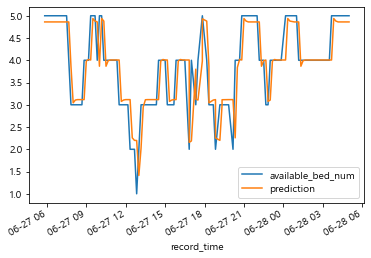

In [172]:
result_GRU(GRU_prediction, train_GRU_prediction, test_data)

# 코드 간략화
다른 병원에서 사용

In [205]:
train_data_len = len(train_data_scaled)
test_data_len = len(test_data_scaled)
time_steps=3
for_periods = 1

x_train, y_train, x_test = xysplit_data(train_data_scaled, test_data_scaled,
                                        train_data_len, test_data_len,
                                        time_steps, for_periods)

In [212]:
# GRU 아키텍처 (architecture )
set_seed()
my_GRU_model = Sequential()
my_GRU_model.add(GRU(units = 64, 
                     return_sequences = True, 
                     input_shape = (x_train.shape[1],1), 
                     activation = 'tanh'))
my_GRU_model.add(GRU(units = 32, 
                     activation = 'tanh'))
my_GRU_model.add(Dropout(0.2))
my_GRU_model.add(Dense(units = 1))

# 컴파일링 (Compiling)
my_GRU_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# 피팅하기 (Fitting)
my_GRU_model.fit(x_train, y_train, epochs = 50, batch_size = 32, verbose = 0)

GRU_prediction = my_GRU_model.predict(x_test)
GRU_prediction = scaler.inverse_transform(GRU_prediction)

x_train_GRU_prediction = my_GRU_model.predict(x_train)
train_GRU_prediction = scaler.inverse_transform(x_train_GRU_prediction)

17/17 [==============================] - 0s 6ms/step


       test result  train result
MAE        0.32728       0.58710
RMSE       0.53505       0.85311
RMSLE      0.12813       0.26858
R2         0.67484       0.67653


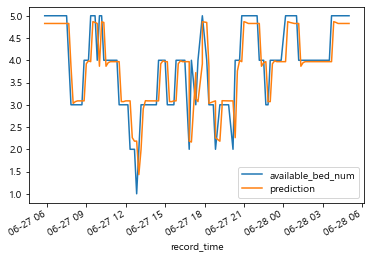

In [213]:
result_GRU(GRU_prediction, train_GRU_prediction, test_data)